# Picnic Hackathon 🥇✅💯
 **When great customer support meets data**


## Why the challenge?
One of our core beliefs is to offer our customers the best support possible, by allowing them, for example, to send in pictures of defect products they wish to be reimbursed for. But processing these pictures is very time-consuming as it is all done manually.

## What is the challenge?
The challenge we propose is the following: As a first step in helping customer support, come up with a way of labeling every picture that comes in according to the product that is in the picture. To keep with the Picnic spirit, we encourage to be as innovative and creative with your solutions as possible.

## Dataset
To that end, we offer the following [dataset](https://github.com/Younes-Charfaoui/Picnic-Hackathon/blob/master/images/picnic_logo.png) of pictures of defect items.

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
from keras_preprocessing.image import ImageDataGenerator

path_to_folder = 'gdrive/My Drive/Dataset/The Picnic Hackathon 2019/'

In [0]:
df = pd.read_csv(path_to_folder + "train.tsv",  sep='\t')

In [0]:
datagen = ImageDataGenerator(rescale=1./255, validation_split = 0.2)

In [0]:
test = ImageDataGenerator(rescale=1./255)

In [0]:
train_generator = datagen.flow_from_dataframe(dataframe=df, directory= "gdrive/My Drive/train/", 
                                              x_col= "file", y_col= "label", 
                                              class_mode= "categorical", 
                                              target_size= (224,224), 
                                              batch_size= 32,
                                              subset = 'training')

valid_generator = datagen.flow_from_dataframe(dataframe=df, directory= "gdrive/My Drive/train/", 
                                              x_col= "file", y_col= "label", 
                                              class_mode= "categorical", 
                                              target_size= (224,224), 
                                              batch_size= 32,
                                              subset = 'validation')


Found 5807 images belonging to 25 classes.
Found 1451 images belonging to 25 classes.


In [0]:
test_generator = datagen.flow_from_directory(directory= path_to_folder +  "test/",
                                              class_mode= "categorical", 
                                              target_size= (224,224), 
                                              batch_size= 32)

Found 0 images belonging to 0 classes.


In [0]:
labels = train_generator.class_indices
labels = {v: k for k, v in labels.items()}

In [0]:
print(labels)

{0: 'Asparagus, string beans & brussels sprouts', 1: 'Bananas, apples & pears', 2: 'Bell peppers, zucchinis & eggplants', 3: 'Berries & cherries', 4: 'Broccoli, cauliflowers, carrots & radish', 5: 'Cheese', 6: 'Citrus fruits', 7: 'Cucumber, tomatoes & avocados', 8: 'Eggs', 9: 'Fish', 10: 'Fresh bread', 11: 'Fresh herbs', 12: 'Kiwis, grapes & mango', 13: 'Lunch & Deli Meats', 14: 'Milk', 15: 'Minced meat & meatballs', 16: 'Nectarines, peaches & apricots', 17: 'Onions, leek, garlic & beets', 18: 'Pineapples, melons & passion fruit', 19: 'Pork, beef & lamb', 20: 'Potatoes', 21: 'Poultry', 22: 'Pre-baked breads', 23: 'Pudding, yogurt & quark', 24: 'Salad & cress'}


In [0]:
"""X_list, y_list = [], []
size = train_generator.n//train_generator.batch_size
print(size)
for i in range(train_generator.n//train_generator.batch_size):
  print(i)
  X, y = train_generator.next()
  X_list.append(X)
  y_list.append(y)"""
  

In [0]:
X_train, y_train = train_generator.next()

In [0]:
X_test, y_test = valid_generator.next()

In [0]:
y.shape

(7258, 25)

In [0]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test, = train_test_split(X, y, shuffle = True, test_size = 0.3)

In [0]:
y = None

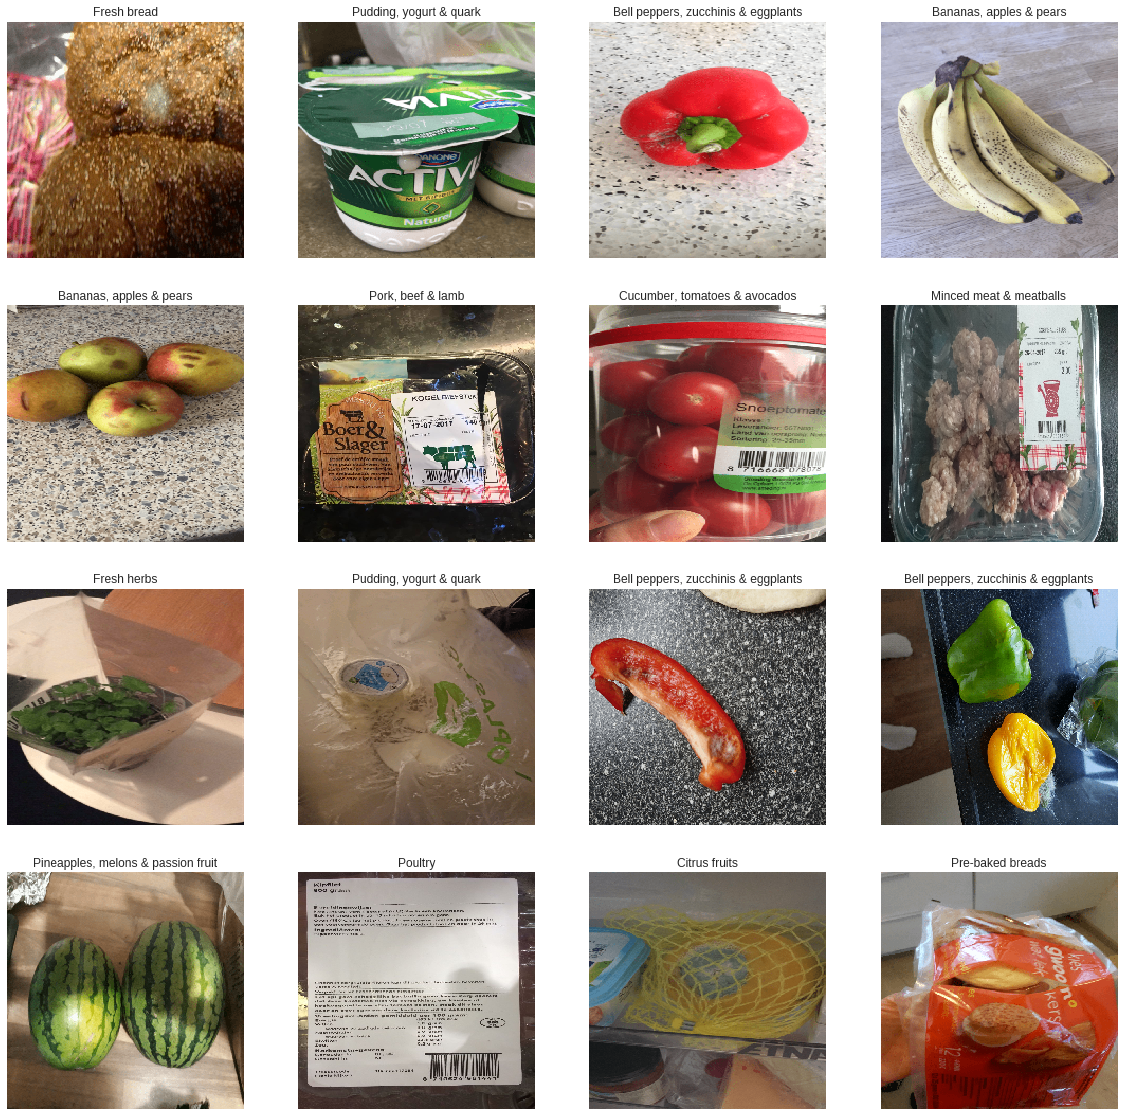

In [0]:
fig = plt.figure(figsize = (20,20))
for i in range(16):
  ax = fig.add_subplot(4,4, i+1, xticks = [], yticks = [])
  ax.imshow(x_train[i])
  ax.set_title(labels[np.argmax(y_train[i])])

In [0]:
from keras.models import Sequential
from keras.layers import Dropout,Conv2D, MaxPooling2D, Activation, Dense, Flatten

Using TensorFlow backend.


In [0]:
# Building simple model
model = Sequential()
model.add(Conv2D(16, (3, 3), padding='same', input_shape=(224,224,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(25, activation='softmax'))
model.summary()


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 16)      448       
_________________________________________________________________
activation_50 (Activation)   (None, 224, 224, 16)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
activation_51 (Activation)   (None, 112, 112, 32)      0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 56, 56, 32)        0         
___________________________

In [0]:
model.compile(optimizer = 'rmsprop', loss="categorical_crossentropy", metrics=["accuracy"])

In [0]:
history = model.fit(x_train, y_train, epochs=100, batch_size = 32)

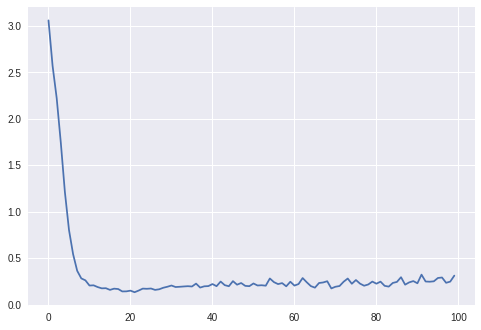

In [0]:
plt.plot(history.history['loss'])
plt.show()

In [0]:
score = model.evaluate(x_test, y_test)
print('Accuracy of {}%'.format(score[1]*100))

2178/2178 [==============================] - 3s 1ms/step
Accuracy of 24.104683195592287%


In [0]:
# Building some complex models
model = Sequential()
model.add(Conv2D(16, kernel_size = (1,1), padding= 'same', input_shape = (32,32,3), activation = 'relu'))
model.add(Conv2D(16, kernel_size = (1,1), padding= 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = 1))
model.add(Conv2D(32, kernel_size = (2,2), padding= 'same', activation = 'relu'))
model.add(Conv2D(64, kernel_size = (2,2), padding= 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = 1))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(512, activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(25, activation = 'softmax'))
model.summary()

In [0]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam' , metrics = ['accuracy'])

In [0]:
history = model.fit([img_train], [lbl_train], epochs=100, batch_size = 32)

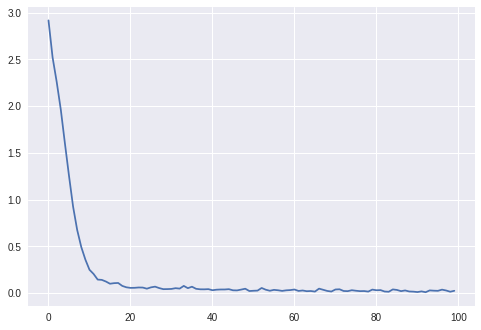

In [0]:
plt.plot(history.history['loss'])
plt.show()

In [0]:
score = model.evaluate([img_test] , [lbl_test])
print('Accuracy of {}%'.format(score[1]*100))

1517/1517 [==============================] - 0s 103us/step
Accuracy of 22.940013188827013%


In [0]:
from keras.applications.resnet50 import ResNet50
model = Sequential()
model.add(ResNet50(include_top=False, weights='imagenet', pooling='avg'))
model.add(Dense(25, activation = 'softmax'))
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
94658560/94653016 [==============================] - 21s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense_1 (Dense)              (None, 25)                51225     
Total params: 23,638,937
Trainable params: 23,585,817
Non-trainable params: 53,120
_________________________________________________________________


In [0]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam' , metrics = ['accuracy'])

In [18]:
model.fit_generator(train_generator, epochs= 12, steps_per_epoch= train_generator.n//train_generator.batch_size, 
                    validation_steps=valid_generator.n//valid_generator.batch_size, 
                    validation_data = valid_generator)

Epoch 1/12


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:885: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


181/181 [==============================] - 997s 6s/step - loss: 0.9174 - acc: 0.7295 - val_loss: 2.1680 - val_acc: 0.4785
Epoch 2/12
181/181 [==============================] - 256s 1s/step - loss: 0.6679 - acc: 0.8015 - val_loss: 1.6168 - val_acc: 0.5638
Epoch 3/12
181/181 [==============================] - 257s 1s/step - loss: 0.4344 - acc: 0.8624 - val_loss: 1.7377 - val_acc: 0.5736
Epoch 4/12
181/181 [==============================] - 256s 1s/step - loss: 0.3278 - acc: 0.8991 - val_loss: 1.6996 - val_acc: 0.5786
Epoch 5/12
181/181 [==============================] - 257s 1s/step - loss: 0.2174 - acc: 0.9368 - val_loss: 2.1899 - val_acc: 0.5701
Epoch 6/12
181/181 [==============================] - 252s 1s/step - loss: 0.2157 - acc: 0.9383 - val_loss: 2.7719 - val_acc: 0.4708
Epoch 7/12
181/181 [==============================] - 254s 1s/step - loss: 0.1245 - acc: 0.9644 - val_loss: 2.7575 - val_acc: 0.5053
Epoch 8/12
181/181 [==============================] - 253s 1s/step - loss: 0.134

In [0]:
history = model.fit(x_train, y_train, epochs=10, batch_size = 32)

Epoch 1/10
5080/5080 [==============================] - 178s 35ms/step - loss: 2.2628 - acc: 0.3793
Epoch 2/10
5080/5080 [==============================] - 147s 29ms/step - loss: 1.4335 - acc: 0.5746
Epoch 3/10
5080/5080 [==============================] - 147s 29ms/step - loss: 1.0462 - acc: 0.6846
Epoch 4/10
5080/5080 [==============================] - 147s 29ms/step - loss: 0.7183 - acc: 0.7843
Epoch 5/10
5080/5080 [==============================] - 147s 29ms/step - loss: 0.4672 - acc: 0.8632
Epoch 6/10
5080/5080 [==============================] - 147s 29ms/step - loss: 0.3403 - acc: 0.8941
Epoch 7/10
5080/5080 [==============================] - 147s 29ms/step - loss: 0.2255 - acc: 0.9295
Epoch 8/10
5080/5080 [==============================] - 147s 29ms/step - loss: 0.2098 - acc: 0.9376
Epoch 9/10
5080/5080 [==============================] - 147s 29ms/step - loss: 0.1583 - acc: 0.9539
Epoch 10/10
5080/5080 [==============================] - 147s 29ms/step - loss: 0.1412 - acc: 0.9587

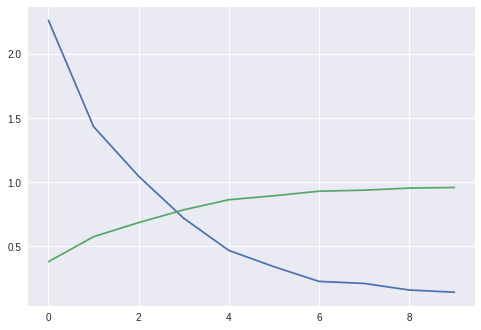

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['acc'])
plt.show()

In [0]:
score = model.evaluate(x_test , y_test)
print('Accuracy of RESNET {}%'.format(score[1]*100))

2178/2178 [==============================] - 27s 13ms/step
Accuracy of RESNET 49.311294765840216%


In [0]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


# Transfer Learning

In [0]:
from keras.applications.resnet50 import ResNet50
model = Sequential()
model.add(ResNet50(include_top=False, weights='imagenet', pooling='avg'))
model.add(Dense(25, activation = 'softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense_4 (Dense)              (None, 25)                51225     
Total params: 23,638,937
Trainable params: 23,585,817
Non-trainable params: 53,120
_________________________________________________________________


In [0]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam' , metrics = ['accuracy'])

In [0]:
model.fit_generator(train_generator, epochs = 10, steps_per_epoch= train_generator.n //train_generator.batch_size)

In [0]:
from keras.applications.resnet50 import ResNet50
from keras.applications.nasnet import NASNetMobile
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications.densenet import DenseNet121
from keras.applications.vgg16 import VGG16
# from keras.applications.resnext import ResNeXt50

def make_model(name):
  model = Sequential()
  if name == 'resnet':
    model.add(ResNet50(include_top=False, weights='imagenet', pooling='avg'))
  #if name == 'resnetxt':
  # model.add(ResNeXt50(include_top=False, weights='imagenet', pooling='avg'))
  elif name == 'mobilenet':
    model.add(MobileNetV2(include_top=False, weights='imagenet', pooling='avg'))
  elif name == 'nasnet':
    model.add(NASNetMobile(include_top=False, weights='imagenet', pooling='avg'))
  elif name == 'densenet':
    model.add(DenseNet121(include_top=False, weights='imagenet', pooling='avg'))
  elif name == 'vgg16':
    model.add(VGG16(include_top=False, weights='imagenet', pooling='avg'))
    
  model.add(Dense(25, activation = 'softmax'))
  model.summary()
  
  return model   

In [0]:
models = ['resnet' , 'mobilenet', 'nasnet', 'densenet', 'vgg16']

In [0]:
def train_model(model, epochs):
  model.compile(loss = 'categorical_crossentropy', optimizer = 'adam' , metrics = ['accuracy'])
  history = model.fit(x_train, y_train, epochs= epochs, batch_size = 32, validation_data= (x_test,y_test))
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.show()
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.show()

In [0]:
model = make_model('resnet')

In [0]:
train_model(model , 50)

29089792/29084464 [==============================] - 1s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 1024)              7037504   
_________________________________________________________________
dense_7 (Dense)              (None, 25)                25625     
Total params: 7,063,129
Trainable params: 6,979,481
Non-trainable params: 83,648
_________________________________________________________________
Train on 5080 samples, validate on 2178 samples
Epoch 1/10
5080/5080 [==============================] - 223s 44ms/step - loss: 1.8820 - acc: 0.4677 - val_loss: 5.4062 - val_acc: 0.3081
Epoch 2/10
5080/5080 [==============================] - 161s 32ms/step - loss: 1.1970 - acc: 0.6419 - val_loss: 2.8472 - val_acc: 0.4426
Epoch 3/10
5080/5080 [==============================] - 161s 32ms/step - loss: 0.8927 - acc: 0.7352 - val_loss: 2.2581 - val_acc: 0.4890

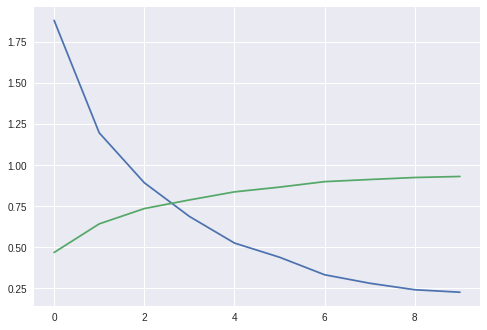

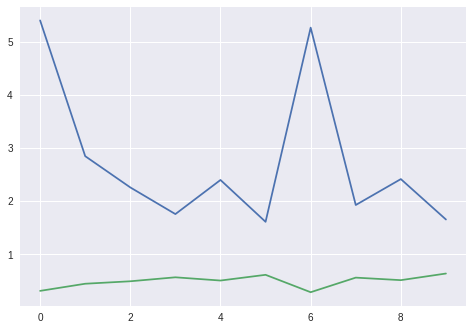

In [0]:
model = make_model('densenet')
train_model(model , 10)

In [0]:
score = model.evaluate(x_test , y_test)
print('Accuracy of {}%'.format(score[1]*100))

2178/2178 [==============================] - 20s 9ms/step
Accuracy of 63.498622589531685%


In [0]:
model.save_weights("densenet.model.h5")

In [0]:
# serialize model to JSON
model_json = model.to_json()
with open("densnetmodel.json", "w") as json_file:
    json_file.write(model_json)

In [0]:
model.predict(x_test)

array([[5.0003751e-04, 3.2603154e-03, 1.6471705e-01, ..., 4.6858427e-04,
        4.9544950e-03, 1.4180497e-03],
       [3.4150954e-03, 1.2694943e-02, 2.4398849e-03, ..., 9.4706882e-03,
        7.8368103e-03, 1.4956337e-01],
       [1.5655806e-06, 9.4944698e-01, 4.6325772e-04, ..., 1.0604979e-05,
        7.8790775e-03, 4.0197468e-05],
       ...,
       [2.9878865e-06, 7.3612290e-03, 1.7576214e-05, ..., 1.9410341e-07,
        9.1622901e-01, 2.8609009e-05],
       [2.4626366e-04, 3.2225795e-04, 1.0782411e-02, ..., 8.4262941e-04,
        7.0387812e-04, 3.8417065e-04],
       [8.0447753e-06, 4.5681357e-02, 5.1895971e-04, ..., 2.3576356e-06,
        1.1665986e-03, 6.0555931e-06]], dtype=float32)

# Exporting Results

In [0]:
import glob
import os
import cv2

In [0]:
files = glob.glob(path_to_folder + 'test/*')

In [0]:
results = []
i = 0
for file in files:
    print(i)
    i+=1
    img = cv2.imread(file,1)
    img = cv2.resize(img, (224, 224)) 
    img = img/255
    result = model.predict([[img]])
    label = labels[np.argmax(result)]
    filename = os.path.basename(file)
    results.append([filename, label])

In [0]:
results[0]

['7552.png', 'Bell peppers, zucchinis & eggplants']

In [0]:
headers = ['file', 'label']
df = pd.DataFrame(results, columns=headers)
df.head()

,file,label
0,7552.png,"Bell peppers, zucchinis & eggplants"
1,7492.png,Fish
2,7467.png,"Onions, leek, garlic & beets"
3,7774.png,"Pork, beef & lamb"
4,7469.png,Eggs


In [0]:
df = df.sort_values(['file'])

In [0]:
df.head()

,file,label
503,7263.jpeg,"Onions, leek, garlic & beets"
520,7264.jpeg,Eggs
571,7265.jpeg,Fresh herbs
332,7266.png,Fish
513,7267.jpeg,Milk


In [0]:
df.to_csv("submission.tsv", sep ='\t', index = False)